## Multiple Traveling Salesman and the Problem of routing vehicles

Imagine we have instead of one salesman traveling to all the sites, that instead the workload is shared among many salesman. This generalization of the traveling salesman problem is called the multiple traveling salesman problem or mTSP. In lots of literature it is studied under the name of Vehicle Routing Problem or [VRP](https://en.wikipedia.org/wiki/Vehicle_routing_problem), but it is equivalent. The problem goes back to the early 1960s where it was applied to oil delivery issues [1]. This is another NP-hard problem so for large amounts of locations a solution might take a long time to find. We can solve it for small values with Pulp though.


[1]: https://andresjaquep.files.wordpress.com/2008/10/2627477-clasico-dantzig.pdf

In [3]:
from pulp import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

### 1. First lets make some fake data

In [39]:
#a handful of sites
sites = ['org','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O']

In [40]:
#make some positions (so we can plot this)
positions = dict( ( a, (np.random.rand()-.5, np.random.rand()-.5)) for a in sites)

positions['org']=(0,0)

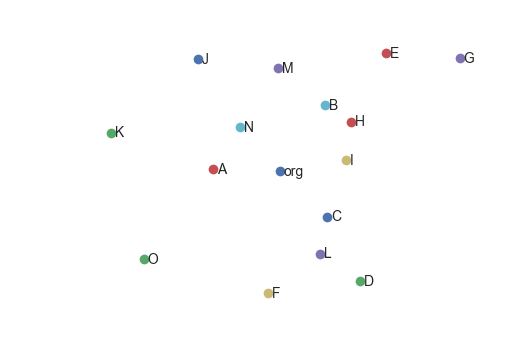

In [41]:
for s in positions:
    p = positions[s]
    plt.plot(p[0],p[1],'o')
    plt.text(p[0]+.01,p[1],s,horizontalalignment='left',verticalalignment='center')
    
plt.gca().axis('off');

In [42]:
#straight line distance for simplicity
d = lambda p1,p2: np.sqrt( (p1[0]-p2[0])**2+ (p1[1]-p2[1])**2)

#cacluate all the pairs
distances=dict( ((s1,s2), d(positions[s1],positions[s2])) for s1 in positions for s2 in positions if s1!=s2)

### 2. The model

With a few modifications, the original traveling salesman problem can support multiple salesman. Instead of making each facility only be visited once, the origin facility will be visited multiple times. If we have two salesman then the origin is visited exactly twice and so on.

For $K$ vehicles or sales people

#### Variables:

indicators:
$$x_{i,j} = \begin{cases}
    1, & \text{if site i comes exactly before j in the tour} \\
    0, & \text{otherwise}
\end{cases}
$$

order dummy variables:
$$u_{i} :  \text{order site i is visited}$$


#### Minimize: 
$$\sum_{i,j \space i \neq j} x_{i,j} Distance(i,j)$$

#### Subject to:

$$\sum_{i \neq j} x_{i,j} = 1 \space \forall j \text{ except the origin}$$
$$\sum_{i \neq j} x_{i,origin} = K$$

$$\sum_{j \neq i} x_{i,j} = 1 \space \forall i \text{ except the origin}$$
$$\sum_{j \neq i} x_{i,origin} = K$$

$$u_{i}-u_{j} \leq  (N \div M)(1-x_{i,j}) - 1 \ \forall i,j \text{ except origins}$$

In [53]:
K = 4 #the number of sales people 

In [54]:
#create the problme
prob=LpProblem("salesman",LpMinimize)

In [55]:
#indicator variable if site i is connected to site j in the tour
x = LpVariable.dicts('x',distances, 0,1,LpBinary)
#dummy vars to eliminate subtours
u = LpVariable.dicts('u', sites, 0, len(sites)-1, LpInteger)

In [56]:
#the objective
cost = lpSum([x[(i,j)]*distances[(i,j)] for (i,j) in distances])
prob+=cost

In [57]:
#constraints
for k in sites:
    cap = 1 if k != 'org' else K
    #inbound connection
    prob+= lpSum([ x[(i,k)] for i in sites if (i,k) in x]) ==cap
    #outbound connection
    prob+=lpSum([ x[(k,i)] for i in sites if (k,i) in x]) ==cap
    
#subtour elimination
N=len(sites)/K
for i in sites:
    for j in sites:
        if i != j and (i != 'org' and j!= 'org') and (i,j) in x:
            prob += u[i] - u[j] <= (N)*(1-x[(i,j)]) - 1

### Solve it!

In [58]:
#%time prob.solve()
prob.solve(GLPK_CMD(options=['--simplex']))
print(LpStatus[prob.status])

Optimal


And the result:

In [59]:
non_zero_edges = [ e for e in x if value(x[e]) != 0 ]

def get_next_site(parent):
    '''helper function to get the next edge'''
    edges = [e for e in non_zero_edges if e[0]==parent]
    for e in edges:
        non_zero_edges.remove(e)
    return edges

In [60]:
tours = get_next_site('org')
tours = [ [e] for e in tours ]

for t in tours:
    while t[-1][1] !='org':
        t.append(get_next_site(t[-1][1])[-1])

The optimal tours:

In [61]:
for t in tours:
    print(' -> '.join([ a for a,b in t]+['org']))

org -> C -> L -> D -> F -> org
org -> A -> K -> O -> org
org -> N -> J -> M -> B -> org
org -> I -> G -> E -> H -> org


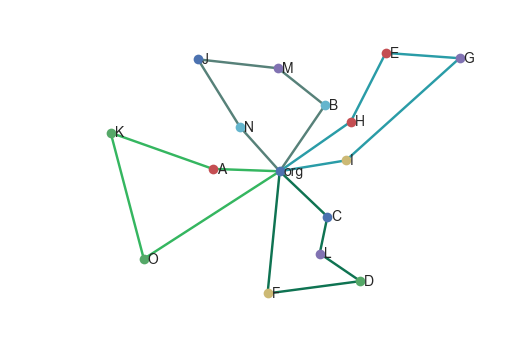

In [62]:
#draw the tours
colors = [np.random.rand(3) for i in range(len(tours))]
for t,c in zip(tours,colors):
    for a,b in t:
        p1,p2 = positions[a], positions[b]
        plt.plot([p1[0],p2[0]],[p1[1],p2[1]], color=c)

#draw the map again
for s in positions:
    p = positions[s]
    plt.plot(p[0],p[1],'o')
    plt.text(p[0]+.01,p[1],s,horizontalalignment='left',verticalalignment='center')
    
plt.gca().axis('off');

In [64]:
print(value(prob.objective))

5.24853860123


### Questions:
1. If we wanted the vehicles/salesman to start and end in different locations, how would we modify this?
2. How can we limit the miles/km each vehicle/salesman drives?
3. How can we incorporate some sort of site priority?
4. How can we incorporate ordering? ie site A must be visited before site B
5. How can we modify the sites per person to be flexible, ie maybe each person must visist between 3 and 6 sites a day